### Dan Aas

In [1]:
import json
import numpy as np
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt
import time
import pandas as pd
import re
%matplotlib inline 
from mpl_toolkits.basemap import Basemap

## Extra Credit - Hella Bay

### Motivation

California is a large state with a heterogenous population. One key dimension variation in identity in California is the split between Northern California (NorCal) and Southern California (SoCal). There are number of differences that could be used to understand why these two regions are distinct. For instance one could look at weather, languages spoken, industry composition and more. However, a key distinction that is brought up in day-to-day conversation is linguistic. NorCal natives make frequent use of the word 'hella', while SoCal natives purport to never speak that word. 

### Research Question

Is the use of the word 'hella' confined to Northern California?

### Methods

In order to evaluate this question, I used a sample of 1 million tweets from across California. I clustered these tweets into 250 georaphic clusters using the mini-batch K-mean algorithm. I then used regex pattern matching to count the number of times the word 'hella' is used in each cluster. Using these counts I developed two new metrics to capture how frequent use of the word 'hella' is in each cluster:

    1) 'Bay %': the ratio of occurances of the word 'hella' in each cluster to the number of tweets in that cluster
    2) 'hella_rating': the ratio of a given clusters 'Bay %' to the cluster with the maximum 'Bay %' value
    
I varied the 'hella_rating' metric to detect in which geographies the word 'hella' is being used.

### Finding

Using various 'hella_rating' screening criteria, it is clear that use of the word is centered around NorCal. In fact, the clusters with the highest 'hella_rating' are all in the Bay Area, especially Alameda County. The 'hella_rating' threshold must be set at very low levels in order for any SoCal clusters to be accounted for. This may provide new evidence about the levels of migration from NorCal to Socal, relative to the total population of Socal.

In [2]:
#parameters
kclust = 250


### Loading JSON and converting to np array

In [3]:
time_start = time.time()
load_start = time.time()


def tweeter(file):
    with open(file,'r') as f:
        tweets = json.load(f)
    x = []
    y = []
    for key in tweets:
        xs = key['lng']
        x.append(xs)
        ys = key['lat']
        y.append(ys)
    x1 = np.array(x)
    y1 = np.array(y)
    xy = np.column_stack((x, y))
    return xy


In [4]:
tweets = 'tweets_1M.json'
all_tweets = tweeter(tweets)

load_time = time.time() - load_start

### Mini-batch K-means

In [5]:
mini_start = time.time()

minik_means = MiniBatchKMeans(init = 'k-means++', n_clusters = kclust, n_init = 10, batch_size = kclust * 3)
minik = minik_means.fit(all_tweets)
mini_labels = minik.labels_

mini_time = time.time() - mini_start 

### Labeling clusters, sorting observation into clusters and paring down

In [18]:
label_start = time.time()

bins_raw = pd.DataFrame(np.column_stack((all_tweets, mini_labels)), columns=['y', 'x', 'bin'])

In [28]:
bins_raw.head()

,y,x,bin,tweets,norcal_count
0,-121.883557,37.446100,105.0,@Tanner_Cortez hey checkout the website: http:...,0
1,-117.462604,34.087406,40.0,@Lennayy7 😪,0
2,-121.842867,37.356131,236.0,i laugh a lot with that line,0
3,-122.009629,37.364664,215.0,sons of anarchy is back on woop woop,0
4,-121.995000,37.382600,215.0,Drinking a Fresh Squeezed IPA by @deschutesbee...,0


In [19]:
def tweetReturn(file):
    with open(file,'r') as f:
        tweets = json.load(f)
    the_tweets = []
    for key in tweets:
        atweet = key['text']
        the_tweets.append(atweet)
    return the_tweets

In [20]:
tweeters = tweetReturn(tweets)

In [21]:
bins_raw['tweets'] = tweeters

This is the regex matching section

In [22]:
norcal = re.compile(r'hella')
bins_raw['norcal_count'] = bins_raw['tweets'].apply(lambda x: len(norcal.findall(x)))

In [23]:
bin_means = bins_raw.groupby('bin').mean()
bin_max = bins_raw.groupby('bin').sum()
bin_count = bins_raw.groupby('bin').count()
bin_plot = bin_means
bin_plot['norcal_count'] = bin_max['norcal_count']
bin_plot['n'] = bin_count['tweets']

In [24]:
bin_plot['bay %'] = bin_plot['norcal_count'] / bin_plot['n']
bin_plot['hella_rating'] = bin_plot['bay %'] / max(bin_plot['bay %'])

In [25]:
centerx = bin_plot['x'].mean()
centery = bin_plot['y'].mean()

#### note
I used code from Chris Albon's blog to build these maps:
http://chrisalbon.com/python/matplotlib_plot_points_on_map.html

### 0.5 hella rating 

The first test was a plot of clusters with a 'hella_rating' of greater than 0.5. Based on this figure, we can conclude that the word 'hella' is indeed a NorCal phenomena. Use of the word also appears to be heavily concentrated in the Bay Area.

In [26]:
bay = bin_plot['hella_rating'] > 0.5

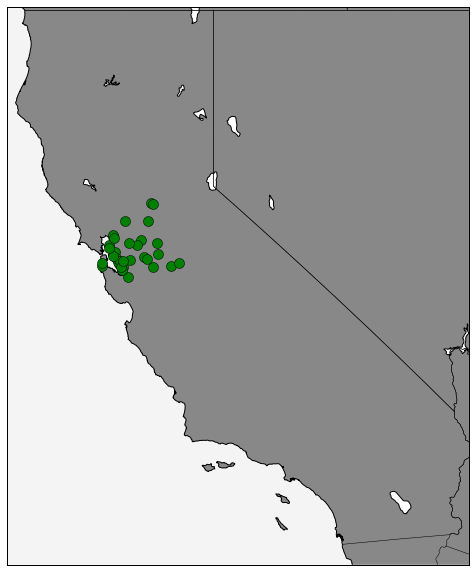

In [35]:
fig = plt.figure(figsize=(20,10))

map = Basemap(projection='merc', lat_0 = centerx, lon_0 = centery,
    resolution = 'h', area_thresh = 100,
    llcrnrlon=-124.6, llcrnrlat=32.15,
    urcrnrlon=-114.3, urcrnrlat=42.05)


map.drawcoastlines()
map.drawcountries()
map.drawstates()
map.fillcontinents(color = '#888888')
map.drawmapboundary(fill_color='#f4f4f4')


x,y = map(bin_plot[bay]['y'].values, bin_plot[bay]['x'].values)
map.plot(x, y, 'go', markersize=10)
 
plt.show()

### 0.8 hella rating

When we increase the 'hella_rating' threshold to 0.8, the Bay-Area-centric nature of the word comes into focus. Only two clusters remain at this threshold, and both are in the Bay Area. In fact, this screening appears to show that Alameda County is the epicenter of 'hella'.

In [25]:
bay = bin_plot['hella_rating'] > 0.8

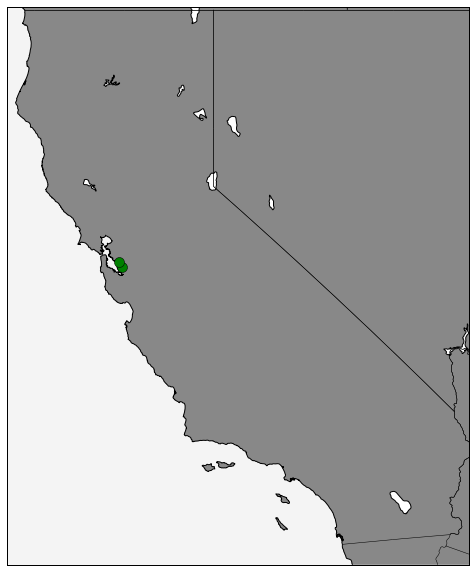

In [26]:
fig = plt.figure(figsize=(20,10))

map = Basemap(projection='merc', lat_0 = centerx, lon_0 = centery,
    resolution = 'h', area_thresh = 100,
    llcrnrlon=-124.6, llcrnrlat=32.15,
    urcrnrlon=-114.3, urcrnrlat=42.05)


map.drawcoastlines()
map.drawcountries()
map.drawstates()
map.fillcontinents(color = '#888888')
map.drawmapboundary(fill_color='#f4f4f4')


x,y = map(bin_plot[bay]['y'].values, bin_plot[bay]['x'].values)
map.plot(x, y, 'go', markersize=10)
 
plt.show()

### 0.2 Hella Rating

When the 'hella_rating' is decreased to 0.2, the geographic scope of clusters that meet the screening criteria increase. In addition to the Central Valley appearing prominently, there is even one cluster in SoCal near San Bernadino.

In [28]:
bay = bin_plot['hella_rating'] > 0.2

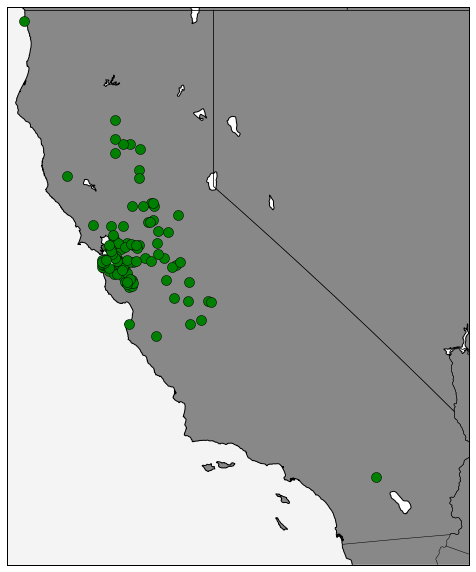

In [29]:
fig = plt.figure(figsize=(20,10))

map = Basemap(projection='merc', lat_0 = centerx, lon_0 = centery,
    resolution = 'h', area_thresh = 100,
    llcrnrlon=-124.6, llcrnrlat=32.15,
    urcrnrlon=-114.3, urcrnrlat=42.05)


map.drawcoastlines()
map.drawcountries()
map.drawstates()
map.fillcontinents(color = '#888888')
map.drawmapboundary(fill_color='#f4f4f4')


x,y = map(bin_plot[bay]['y'].values, bin_plot[bay]['x'].values)
map.plot(x, y, 'go', markersize=10)
 
plt.show()

### > 0 Hella Rating

The final test applies a screening criteria that allows any cluster where the word 'hella' appears to be accounted for. This case shows that 'hella' is used throughout the state--though at very low levels.

In [30]:
bay = bin_plot['hella_rating'] > 0

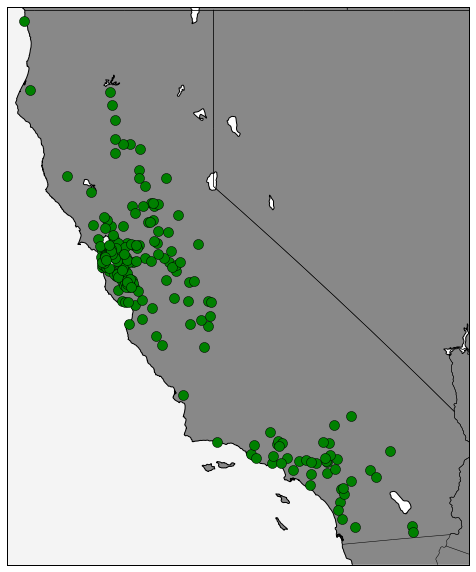

In [31]:
fig = plt.figure(figsize=(20,10))

map = Basemap(projection='merc', lat_0 = centerx, lon_0 = centery,
    resolution = 'h', area_thresh = 100,
    llcrnrlon=-124.6, llcrnrlat=32.15,
    urcrnrlon=-114.3, urcrnrlat=42.05)

map.drawcoastlines()
map.drawcountries()
map.drawstates()
map.fillcontinents(color = '#888888')
map.drawmapboundary(fill_color='#f4f4f4')

x,y = map(bin_plot[bay]['y'].values, bin_plot[bay]['x'].values)
map.plot(x, y, 'go', markersize=10)
 
plt.show()